<a href="https://colab.research.google.com/github/s-c-soma/deep_context_graph/blob/main/code/StatementChecker_KnowledgeGraph_SemanticRelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two variation: 
1. summarize ->graph :: .buildGraph(.summarize(text))
2. distillation -> graph :: .buildGraph(.distill(text))


# **Env Setup**


In [1]:


# Mount google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=False)


# create folder to write data to
#CIS545_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS545_2020')
#HOMEWORK_FOLDER=os.path.join(CIS545_FOLDER, 'Project')
#os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

KeyboardInterrupt: ignored

In [ ]:
!ls '/content/drive/Shared drives/1DeepContextGraph/1DeepContextGraph'

code  documents


In [49]:
file_path = '/content/drive/Shared drives/1DeepContextGraph/1DeepContextGraph/code/data/'

# Library

In [1]:
!pip install sentence-transformers

     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 2.1MB 21.0MB/s 
     |████████████████████████████████| 1.2MB 60.1MB/s 
     |████████████████████████████████| 901kB 38.8MB/s 
     |████████████████████████████████| 3.3MB 50.1MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=ceae6d3d2c6c1cac34cf6bfd1e01da0cca7fda41f710f22562427757b615e450
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers


In [2]:
!pip install LexRank

     |████████████████████████████████| 71kB 6.5MB/s 


In [3]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [4]:
#import lexrank.degree_centrality_scores

from lexrank import STOPWORDS, LexRank
from path import Path


In [5]:
import json
import os
# For caculating approximate time to process notebook (IGNORE)
import datetime
datetime.datetime.now()
import argparse
import pandas as pd
import numpy as np
import operator
import pickle as pkl 
import matplotlib.pyplot as plt
import nltk as nl
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import ParameterGrid
import statistics
import random
import warnings
from string import punctuation
from matplotlib import pyplot
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from spacy import displacy 
import nltk
import re
import io
import requests
import time
import gensim
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import nltk.sentiment
from sentence_transformers import SentenceTransformer, util
import numpy as np
import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('brown')

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

# Load Data

In [7]:
data_fox_claim = pd.read_csv(file_path+'/fox_claim_news_processed.csv',low_memory=False)
#data_all_news = pd.read_csv(file_path+'/statement_checker_all.csv',low_memory=False)
data_polifact = pd.read_csv(file_path+'/political_fact_checker_processed.csv',low_memory=False)


In [8]:
data_fox_claim.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'link', 'published', 'title', 'text',
       'site', 'text_distilled', 'topics', 'named_entity_recognition',
       'top_10_freq_word', 'pasts_of_speech'],
      dtype='object')

In [9]:
data_polifact.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'sources', 'urls', 'title', 'summaries',
       'dates', 'ratings', 'text', 'authors', 'publishdate', 'relatedlinks',
       'claims', 'text_distilled', 'topics', 'named_entity_recognition',
       'top_10_freq_word', 'pasts_of_speech'],
      dtype='object')

In [10]:
data_fox_claim['Unnamed: 0'][1]

1

In [11]:
data_fox_claim = data_fox_claim.rename({'Unnamed: 0': 'documentId'}, axis='columns')
data_polifact = data_polifact.rename({'Unnamed: 0': 'documentId'}, axis='columns')

# Methods

## Lemmatization
  
First, the raw words must be converted to root forms.  

In [6]:
def lemmatize(tokenized_words):
  text = [nltk.WordNetLemmatizer().lemmatize(word) for word in tokenized_words]
  return text


## Removing Stop words



In [7]:
english_stopwords = set(stopwords.words('english') + list(punctuation) + [''])

def remove_stopwords(tokenized_words):
  text = [word for word in tokenized_words if word not in english_stopwords]
  return text


## Custom Filtering

Some of the one or two-letter words from the tokenized words are also removed to further cleanse the raw text. 

In [8]:
whitelist = set(['ai', 'ax', 'ca', 'eu', 'go', 'io', 'la', 'ox', 'us', 'uk', 
                 'al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 
                 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi',
                 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny',
                 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn',
                 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy' ])
def remove_too_short(tokenized_words):
  text = [word for word in tokenized_words if (len(word) >= 3 or word not in whitelist) ]
  return text

## LDA Analysis


In [9]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

def topics(tokenized_words):
    d = Dictionary([tokenized_words])
    c = [d.doc2bow(tokenized_words)]
    m = LdaModel(c, num_topics=1, id2word=d)
    return list(m.print_topics(num_words=2))
  


## Topics as Simple List of Words

A list of topic terms is compiled as show below. The coefficients in front of each word are dropped as part of simplification. The assumption is that the top two words comprising the topic, are both significant enough to be treated equally. It is important that the goal is to build a reliable prediction model. While there is a risk of oversimplification, if the final model results in a poor accuracy score, the coefficient can always be reintroduced here.

In [10]:
def parseTopics(topics):
   output = []
   words = topics[0][1].split( '+' )
   for word in words:
       output.append( word.split('*')[1].replace( '"', '' ) )
   return output

# Information extraction and knowledge graphs

* https://programmerbackpack.com/python-nlp-tutorial-information-extraction-and-knowledge-graphs/
* https://github.com/bdmarius/python-knowledge-graph

## Methods

In [11]:
def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    #deps = ["compound", "prep", "conj", "mod","nsubj","quantmod","dobj","poss","pobj"] #
    #deps = ["compound", "prep", "conj", "mod", "quantmod", "dobj"] #,"poss"
    deps = ["compound", "prep", "conj", "mod","nsubj"]
    return any(subs in token.dep_ for subs in deps)
'''
Mellon ... nsubj .... ORG
from ... prep .... 
Pan ... compound .... ORG
Am ... compound .... ORG
Systems ... pobj .... ORG
donated ... ROOT .... 
$ ... quantmod .... MONEY
10 ... compound .... MONEY
million ... dobj .... MONEY
to ... prep .... 
Trump ... poss .... PERSON
's ... case .... 
campaign ... pobj .... 
. ... punct .... 
'''
def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    # plt.figure(figsize=(8, 6), dpi=80)
    # nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
    #         node_size=500, node_color='seagreen', alpha=0.9,
    #         labels={node: node for node in G.nodes()})
    # plt.axis('off')

    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)


    plt.show()

## Example and Experiment

In [ ]:
text = "London is the capital and largest city of England and the United Kingdom. Standing on the River " \
           "Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to " \
           "the North Sea, London has been a major settlement for two millennia. " \
           "Londinium was founded by the Romans. The City of London, " \
           "London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as " \
           "the Square Mile − retains boundaries that follow closely its medieval limits." \
           "The City of Westminster is also an Inner London borough holding city status. " \
           "Greater London is governed by the Mayor of London and the London Assembly." \
           "London is located in the southeast of England." \
           "Westminster is located in London." \
           "London is the biggest city in Britain. London has a population of 7,172,036."


In [ ]:
summary = """ The Chrysler Building, the famous art deco New York skyscraper, will be
 sold for a small fraction of its previous sales price. The building sold fairly 
 quickly after being publicly placed on the market only two months ago. The incentive 
 to sell the building at such a huge loss was due to the soaring rent the owners pay to 
 Cooper Union, a New York college, for the land under the building.' Still the building is 
among the best known in the city, even to people who have never been to New York. """

In [ ]:
body = summary
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))

The -> det
Chrysler -> compound
Building -> nsubj
, -> punct
the -> det
famous -> amod
art -> compound
deco -> compound
New -> compound
York -> compound
skyscraper -> appos
, -> punct
will -> aux
be -> ROOT

  -> 
sold -> advcl
for -> prep
a -> det
small -> amod
fraction -> pobj
of -> prep
its -> poss
previous -> amod
sales -> compound
price -> pobj
. -> punct
Building , famous be small previous , fraction price
The -> det
building -> nsubj
sold -> ROOT
fairly -> advmod

  -> 
quickly -> advmod
after -> prep
being -> auxpass
publicly -> advmod
placed -> pcomp
on -> prep
the -> det
market -> pobj
only -> advmod
two -> nummod
months -> npadvmod
ago -> advmod
. -> punct
building , sell , market
The -> det
incentive -> nsubj

  -> 
to -> aux
sell -> relcl
the -> det
building -> dobj
at -> prep
such -> predet
a -> det
huge -> amod
loss -> pobj
was -> ROOT
due -> acomp
to -> prep
the -> det
soaring -> amod
rent -> pobj
the -> det
owners -> nsubj
pay -> relcl
to -> prep

  -> 
Cooper -> compo

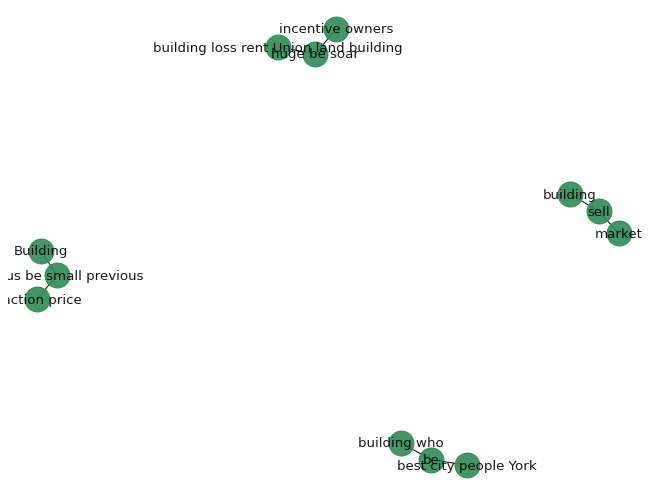

In [ ]:
printGraph(triples)  

## Knowledge graph FoxClaim

In [ ]:
data_fox_claim.head(1)

In [ ]:
data_fox_claim.columns

In [ ]:
body = data_fox_claim['title'][0]
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))

In [ ]:
printGraph(triples) 

## Knowledge graph Politifact

In [ ]:
data_polifact.head(1)

In [ ]:
data_polifact.columns

In [ ]:
body = data_polifact['title'][0]
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))

In [ ]:
printGraph(triples) 

# Use Case: Political Donation Knowledge Graph for Trump

* news: 
https://www.washingtonpost.com/politics/timothy-mellon-top-donor-to-trump-super-pac-used-racial-stereotypes-to-describe-african-americans-in-his-autobiography/2020/06/18/89206c5a-a742-11ea-b619-3f9133bbb482_story.html

* ref: 
https://programmerbackpack.com/python-nlp-tutorial-information-extraction-and-knowledge-graphs/

In [181]:
!pip install newspaper3k

## Get Text
https://analyticsindiamag.com/hands-on-guide-to-extractive-text-summarization-with-bertsum/

In [182]:
from newspaper import fulltext
import requests
#article_url="https://www.washingtonpost.com/politics/timothy-mellon-top-donor-to-trump-super-pac-used-racial-stereotypes-to-describe-african-americans-in-his-autobiography/2020/06/18/89206c5a-a742-11ea-b619-3f9133bbb482_story.html "
article_url = "https://www.investopedia.com/articles/investing/033116/top-10-corporate-contributors-trump-campaign.asp"
article_url = "https://patch.com/california/beverlyhills/beverly-hills-home-trumps-biggest-california-donor"
article = fulltext(requests.get(article_url).text)
print(article)

Politics & Government Beverly Hills Home To Trump's Biggest California Donor Beverly Hills has donated a staggering $9,337,672 to Trump's re-election campaign, much of it from real estate developer Geoffrey Palmer. Replies (3)

Geoffrey Palmer, Trump's biggest California donor, gave $6,405,200 through July. (Shutterstock)

BEVERLY HILLS, CA — Despite its reputation as a liberal enclave, Beverly Hills has emerged as Trump's top source of cash in California.

According to a Los Angeles Times report tracking total donations town by town, Beverly Hills donated a total of $9,337,672 to the president's re-election campaign, and was one of the few communities on the Westside where he outraised Joe Biden.

Much of that total came from real estate developer Geoffrey Palmer, whose $6,405,200 was the largest individual donation in California. Palmer is a long-time Trump and Republican donor who donated a total of $7,005,400 to the Trump campaign during the 2016 cycle. In September 2019 Trump visi

In [183]:
article

"Politics & Government Beverly Hills Home To Trump's Biggest California Donor Beverly Hills has donated a staggering $9,337,672 to Trump's re-election campaign, much of it from real estate developer Geoffrey Palmer. Replies (3)\n\nGeoffrey Palmer, Trump's biggest California donor, gave $6,405,200 through July. (Shutterstock)\n\nBEVERLY HILLS, CA — Despite its reputation as a liberal enclave, Beverly Hills has emerged as Trump's top source of cash in California.\n\nAccording to a Los Angeles Times report tracking total donations town by town, Beverly Hills donated a total of $9,337,672 to the president's re-election campaign, and was one of the few communities on the Westside where he outraised Joe Biden.\n\nMuch of that total came from real estate developer Geoffrey Palmer, whose $6,405,200 was the largest individual donation in California. Palmer is a long-time Trump and Republican donor who donated a total of $7,005,400 to the Trump campaign during the 2016 cycle. In September 2019 T

## Get Summary from Text

In [13]:
## computed using my BERT Model Summarization
summary = '''
In a self-published 2015 autobiography, Mellon called social safety net programs “Slavery Redux,” adding: “For delivering their votes in the Federal Elections, they are awarded with yet more and more freebies: food stamps, cell phones, WIC payments, Obamacare, and on, and on, and on. Advertisement

Story continues below advertisement

Mellon declined to comment. Mellon, who is the great-grandson of Mellon family patriarch and banker Thomas Mellon, and grandson of Andrew W. Mellon, the former Treasury Department secretary, had given smaller amounts to state and federal GOP candidates for years, 
but ramped up his giving under Trump, campaign finance records show. Story continues below advertisement

He now rivals other prominent donors who have increased their political giving under Trump, 
such as shipping supplies magnate Richard Uihlein and Stephen Schwarzman, the Blackstone chairman and chief executive. 
Black people, in spite of heroic efforts by the ‘Establishment’ to right the wrongs of the past, became even more belligerent and unwilling to pitch in to improve their own situations,” Mellon wrote, describing his view of America during Reagan’s 1984 reelection campaign. Advertisement

Two decades later, too many Americans are still relying on the government for help, 
he wrote. In the 1980s, Mellon took over a rail company called Guilford Transportation Industries and rebranded it after purchasing Pan Am Airways from bankruptcy in the 1990s. Advertisement

He gave another $10 million to the Congressional Leadership Fund in November 2019. The Congressional Leadership Fund did not respond to requests for comment.'''

## Create Graph

In [16]:
body = article#summary
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))

Donald -> compound
Trump -> nsubj
announced -> ROOT
his -> poss
reelection -> compound
bid -> dobj
as -> advmod
soon -> advmod
as -> mark
he -> nsubj
took -> advcl
office -> dobj
four -> nummod
years -> npadvmod
ago -> advmod
and -> cc
raised -> conj
over -> quantmod
$ -> quantmod
1 -> compound
billion -> dobj
in -> prep
the -> det
2020 -> nummod
cycle -> pobj
, -> punct
according -> prep
to -> prep
OpenSecrets -> pobj
. -> punct
Trump he , announce , bid office billion cycle OpenSecrets
This -> det
amount -> nsubj
includes -> ROOT
donations -> dobj
to -> prep
his -> poss
official -> amod
campaign -> compound
committee -> pobj
and -> cc
outside -> amod
groups -> conj
like -> prep
single -> amod
- -> punct
candidate -> nmod
super -> amod
PACs -> pobj
and -> cc
hybrid -> amod
PACs -> conj
or -> cc
Carey -> compound
Committees -> conj
. -> punct
amount , include official outside single super hybrid , donations committee PACs
Where -> advmod
Did -> aux
the -> det
Big -> compound
Money -> n

In [17]:
triples

[('Trump he', 'announce', 'bid office billion cycle OpenSecrets'),
 ('amount',
  'include official outside single super hybrid',
  'donations committee PACs'),
 ('Money', 'go', ''),
 ('donations individual',
  'large presidential direct super hybrid official',
  'elections PACs limit much committee cycle'),
 ('Action',
  'single trump super be primary recipient wealthy',
  'April agenda victory funds backers'),
 ('Millions it it we who',
  'come super affiliate dark',
  'dollars PAC nonprofit donors group it'),
 ('supporters',
  'give joint presidential Committee',
  'committees campaign example Victory'),
 ('industries cycle', 'demographic big be Services', 'donors'),
 ('8,021', 'come former', 'pockets million 2016'),
 ('following', 'be top donor process * * *', 'campaign data'),
 ('They', 'give', 'PAC'),
 ('his', 'Mellon former be big cycle', 'fortune Secretary donations'),
 ('He which', 'own large regional', 'railroad America sale July'),
 ('He', 'be', 'politics'),
 ('operatives he'

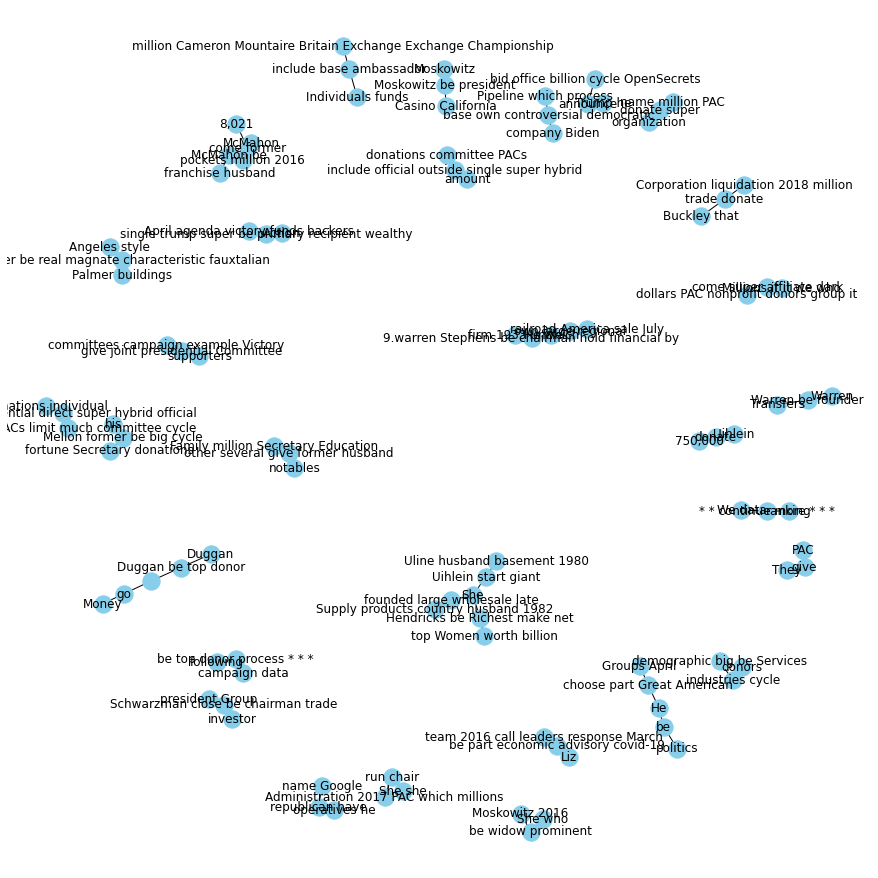

In [18]:
printGraph(triples)  

# Semantic Relationships - Not working

https://programmerbackpack.com/python-knowledge-graph-understanding-semantic-relationships/

In [17]:
from nltk import Tree

def buildTree(token):
    if token.n_lefts + token.n_rights > 0:
        return Tree(token, [buildTree(child) for child in token.children])
    else:
        return buildTree(token)

In [18]:
class Relation:

    __hypernym: str
    __hyponym: str

    def __init__(self, hypernym, hyponym):
        self.__hypernym = hypernym
        self.__hyponym = hyponym

    def getHypernym(self):
        return self.__hypernym

    def getHyponym(self):
        return self.__hyponym

In [20]:
!pip install relation

ERROR: Could not find a version that satisfies the requirement relation (from versions: none)
ERROR: No matching distribution found for relation


In [21]:
#from relation import Relation

class RelationProvider:

    __relations: [Relation]

    def __init__(self, relations=[Relation]):
        self.__relations = relations

    def getRelations(self):
        return self.__relations

In [22]:
#import wikipedia


class TextExtractor:

    __pageTitle: str
    __pageId: str

    def __init__(self, pageTitle, pageId):
        self.__pageTitle = pageTitle
        self.__pageId = pageId

    def extract(self):
        page = wikipedia.page(title=self.__pageTitle, pageid=self.__pageId)
        f = open("./text/" + self.__pageTitle + ".txt", "w")
        f.write(page.content)
        f.close()

    def getText(self):
        f = open("./text/" + self.__pageTitle + ".txt", "r")
        return f.read()

In [23]:
#from text_extractor import TextExtractor


class TextExtractorPipe:

    __textExtractors: [TextExtractor]

    def __init__(self):
        self.__textExtractors = []

    def addTextExtractor(self, textExtractor: TextExtractor):
        self.__textExtractors.append(textExtractor)

    def extract(self) -> str:
        result = ''
        for textExtractor in self.__textExtractors:
            result = result + textExtractor.getText()
        return result

In [24]:
from spacy.matcher import Matcher
from abc import abstractmethod
from spacy.tokens import Doc
# from relation import Relation


class PatternMatcher:


    def __init__(self, pattern, nlp, matcherId):
        self._nlp = nlp
        self._matcher = Matcher(nlp.vocab)
        self._matcher.add(matcherId, None, pattern)

    @abstractmethod
    def getRelations(self, doc: Doc) -> [Relation]:
        ...

In [25]:
# from pattern_matcher import PatternMatcher
from spacy.tokens import Doc
# from relation import Relation


class AndOtherPatternMatcher(PatternMatcher):


    def __init__(self, nlp):
        pattern = [{'POS': 'NOUN'},
                   {'LOWER': 'and'},
                   {'LOWER': 'other'},
                   {'POS': 'NOUN'}]
        PatternMatcher.__init__(self, pattern, nlp, "andOther")

    def getRelations(self, doc: Doc) -> [Relation]:
        relations = []
        matches = self._matcher(doc)
        for match_id, start, end in matches:
            span = doc[start:end]
            firstToken = span.root.head
            results = [firstToken]
            while firstToken and firstToken.head.pos_ == "NOUN":
                results.append(firstToken.head)
                firstToken = firstToken.head
            hypernym = span.text.split()[-1]
            relations.append(Relation(hypernym, span.text.split()[0]))
            if len(results) > 0:
                for result in results:
                    relations.append(Relation(hypernym, result.text))
        return relations

## Implementation

In [26]:
hypernym = span.text.split()[-1]

NameError: ignored

In [27]:
relations.append(Relation(hypernym, span.text.split()[0]))

NameError: ignored

In [28]:
# from pattern_matcher import PatternMatcher
from spacy.tokens import Doc
# from relation import Relation


class OrOtherPatternMatcher(PatternMatcher):

    def __init__(self, nlp):
        pattern = [{'POS': 'NOUN'},
                   {'LOWER': 'or'},
                   {'LOWER': 'other'},
                   {'POS': 'NOUN'}]
        PatternMatcher.__init__(self, pattern, nlp, "orOther")

    def getRelations(self, doc: Doc) -> [Relation]:
        relations = []
        matches = self._matcher(doc)
        for match_id, start, end in matches:
            span = doc[start:end]
            firstToken = span.root.head
            results = [firstToken]
            while firstToken and firstToken.head.pos_ == "NOUN":
                results.append(firstToken.head)
                firstToken = firstToken.head
            hypernym = span.text.split()[-1]
            relations.append(Relation(hypernym, span.text.split()[0]))
            if len(results) > 0:
                for result in results:
                    relations.append(Relation(hypernym, result.text))
        return relations

In [29]:
# from pattern_matcher import PatternMatcher
from spacy.tokens import Doc
# from relation import Relation


class EspeciallyPatternMatcher(PatternMatcher):

    def __init__(self, nlp):
        pattern = [{'POS': 'NOUN'},
                   {'IS_PUNCT': True, 'OP': '?'},
                   {'LOWER': 'especially'},
                   {'POS': 'NOUN'}]
        PatternMatcher.__init__(self, pattern, nlp, "especially")

    def getRelations(self, doc: Doc) -> [Relation]:
        relations = []
        matches = self._matcher(doc)
        for match_id, start, end in matches:
            span = doc[start:end]
            candidates = set()
            for sent in doc.sents:
                for token in sent:
                    # Find relation
                    if token.i == span.root.i:
                        for token2 in sent:
                            # First hyponym
                            if token2.head.i == token.i:
                                for token3 in sent:
                                    startToken = token3
                                    while startToken and startToken.head.i != sent.root.i and startToken.i != token2.i:
                                        if startToken.pos_ == "NOUN":
                                            candidates.add(startToken)
                                        startToken = startToken.head
            if len(candidates) > 0:
                hypernym = span.text.split()[0].replace(',', '')
                for candidate in candidates:
                    relations.append(Relation(hypernym, candidate.text))

        return relations

In [30]:
# from pattern_matcher import PatternMatcher
from spacy.tokens import Doc
# from relation import Relation


class IncludingPatternMatcher(PatternMatcher):

    def __init__(self, nlp):
        pattern = [{'POS': 'NOUN'},
                   {'IS_PUNCT': True, 'OP': '?'},
                   {'LOWER': 'including'},
                   {'POS': 'NOUN'}]
        PatternMatcher.__init__(self, pattern, nlp, "including")

    def getRelations(self, doc: Doc) -> [Relation]:
        relations = []
        matches = self._matcher(doc)
        for match_id, start, end in matches:
            span = doc[start:end]
            for sent in doc.sents:
                for token in sent:
                    # Find the relation
                    if token.text == "including" and token.head.i == span.root.i:
                        for token2 in sent:
                            # First hyponym
                            if token2.head.i == token.i:
                                results = set()
                                results.add(span.text.split()[-1])
                                # Other hyponyms
                                for token3 in sent:
                                    startToken = token3
                                    while startToken and startToken.head.i != sent.root.i and startToken.i != token2.i:
                                        if startToken.pos_ == "NOUN":
                                            results.add(startToken.text)
                                        startToken = startToken.head
                                if len(results) > 0:
                                    hypernym = span.text.split()[0].replace(',', '')
                                    for result in results:
                                        relations.append(Relation(hypernym, result))
        return relations

In [31]:
# from pattern_matcher import PatternMatcher
from spacy.tokens import Doc
# from relation import Relation


class SuchAsPatternMatcher(PatternMatcher):


    def __init__(self, nlp):
        pattern = [{'POS': 'NOUN'},
                   {'IS_PUNCT': True, 'OP': '?'},
                   {'LOWER': 'such'},
                   {'LOWER': 'as'},
                   {'POS': 'NOUN'}]
        PatternMatcher.__init__(self, pattern, nlp, "suchAs")

    def getRelations(self, doc: Doc) -> [Relation]:
        relations = []
        matches = self._matcher(doc)
        for match_id, start, end in matches:
            span = doc[start:end]
            hypernym = span.root.text
            hyponym = span.text.split()[-1]
            relations.append(Relation(hypernym, hyponym))
            for right in span.rights:
                if right.pos_ == "NOUN":
                    relations.append(Relation(hypernym, right.text))
        return relations

In [33]:
# from pattern_matcher import PatternMatcher
# from relation import Relation
from spacy.tokens import Doc


class MatcherPipe:

    __matchers: [PatternMatcher]

    def __init__(self):
        self.__matchers = []

    def addMatcher(self, matcher: PatternMatcher):
        self.__matchers.append(matcher)

    def extract(self, doc: Doc) -> [Relation]:
        results = []
        for matcher in self.__matchers:
            results.extend(matcher.getRelations(doc))
        return results

## knowledge_graph.py

In [34]:
# from relation import Relation
import networkx as nx
import matplotlib.pyplot as plt

class KnowledgeGraph:

    __relations: [Relation]
    __graph: nx.Graph
    __colors: {}

    def __init__(self, relations):
        self.__relations = relations
        self.__graph = nx.Graph()
        self.__colors = {}

    def build(self):
        for relation in self.__relations:
            self.__graph.add_node(relation.getHypernym())
            self.__colors[relation.getHypernym()] = '#e34234'
            self.__graph.add_node(relation.getHyponym())
            self.__colors[relation.getHyponym()] = '#009966'
            self.__graph.add_edge(relation.getHypernym(), relation.getHyponym())

    def show(self):
        pos = nx.spring_layout(self.__graph)
        plt.figure()
        colorMap = []
        for node in self.__graph.nodes:
            colorMap.append(self.__colors[node])
        nx.draw(self.__graph, pos, edge_color='black', width=1, linewidths=1,
                node_size=500, node_color=colorMap, alpha=0.9,
                labels={node: node for node in self.__graph.nodes()})
        plt.axis('off')
        plt.show()

## build_knowledge_graph.py

In [ ]:
from text_extractor import TextExtractor
from and_other_pattern_matcher import AndOtherPatternMatcher
from such_as_pattern_matcher import SuchAsPatternMatcher
from or_other_pattern_matcher import OrOtherPatternMatcher
from including_pattern_matcher import IncludingPatternMatcher
from especially_pattern_matcher import EspeciallyPatternMatcher
from text_extractor_pipe import TextExtractorPipe
from knowledge_graph import KnowledgeGraph
from matcher_pipe import MatcherPipe
import spacy

textExtractor1 = TextExtractor("WWII", "Q362")
textExtractor1.extract()
textExtractor2 = TextExtractor("London", "Q84")
textExtractor2.extract()
textExtractor3 = TextExtractor("Paris", "Q90")
textExtractor3.extract()
textExtractor4 = TextExtractor("World War I", "Q361")
textExtractor4.extract()
textExtractorPipe = TextExtractorPipe()
textExtractorPipe.addTextExtractor(textExtractor1)
textExtractorPipe.addTextExtractor(textExtractor2)
textExtractorPipe.addTextExtractor(textExtractor3)
textExtractorPipe.addTextExtractor(textExtractor4)


nlp = spacy.load('en_core_web_sm')
nlp.add_pipe(nlp.create_pipe('sentencizer')) # updated
doc = nlp(textExtractorPipe.extract())

andOtherPatternMatcher = AndOtherPatternMatcher(nlp)
suchAsMatcher = SuchAsPatternMatcher(nlp)
orOtherMatcher = OrOtherPatternMatcher(nlp)
includingPatternMatcher = IncludingPatternMatcher(nlp)
especiallyPatternMatcher = EspeciallyPatternMatcher(nlp)
matcherPipe = MatcherPipe()
matcherPipe.addMatcher(andOtherPatternMatcher)
matcherPipe.addMatcher(suchAsMatcher)
matcherPipe.addMatcher(orOtherMatcher)
matcherPipe.addMatcher(includingPatternMatcher)
matcherPipe.addMatcher(especiallyPatternMatcher)
relations = matcherPipe.extract(doc)

for relation in relations:
    print (relation.getHypernym(), relation.getHyponym())

knowledgeGraph = KnowledgeGraph(relations)
knowledgeGraph.build()
knowledgeGraph.show()

# Upgrade Mehtods

In [12]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

## Input Test

In [13]:
text = '''This April, Mr. Mellon gave another $10 million, this time to President Trump’s super PAC,
 America First Action, the only Trump-endorsed fund-raising group permitted to collect unlimited 
 contributions. The fact that an outsider like Mr. Mellon has emerged as one of the few 
 supporters willing to be so generous illustrates a surprising problem for the president: 
 his struggle to attract and retain a reliable stable of millionaires and billionaires willing 
 to write seven-figure checks, despite his takeover of the Republican 
Party and a policy agenda that largely serves the interests of America’s ultrawealthy. '''

In [14]:
article = text

In [19]:
text

'This April, Mr. Mellon gave another $10 million, this time to President Trump’s super PAC,\n America First Action, the only Trump-endorsed fund-raising group permitted to collect unlimited \n contributions. The fact that an outsider like Mr. Mellon has emerged as one of the few \n supporters willing to be so generous illustrates a surprising problem for the president: \n his struggle to attract and retain a reliable stable of millionaires and billionaires willing \n to write seven-figure checks, despite his takeover of the Republican \nParty and a policy agenda that largely serves the interests of America’s ultrawealthy. '

In [15]:
text = article
summary = article

## get_NER

In [13]:
doc = nlp("Mellon from Pan Am Systems donated $10 million to Trump's campaign.")

for tok in doc:
  print(tok.text, "...", tok.dep_, "....", tok.ent_type_)

Mellon ... nsubj .... ORG
from ... prep .... 
Pan ... compound .... ORG
Am ... compound .... ORG
Systems ... pobj .... ORG
donated ... ROOT .... 
$ ... quantmod .... MONEY
10 ... compound .... MONEY
million ... dobj .... MONEY
to ... prep .... 
Trump ... poss .... PERSON
's ... case .... 
campaign ... pobj .... 
. ... punct .... 


In [14]:
doc = nlp("Mellon gave 100 million donation to Trump's campaign")

for tok in doc:
  print(tok.text, "...", tok.dep_, "....", tok.ent_type_)

Mellon ... nsubj .... ORG
gave ... ROOT .... 
100 ... compound .... CARDINAL
million ... nummod .... CARDINAL
donation ... dobj .... 
to ... prep .... 
Trump ... poss .... PERSON
's ... case .... 
campaign ... pobj .... 


In [16]:
doc = nlp(summary)

for tok in doc:
  #print(tok.text, "...", tok.dep_, "--", tok.ent_type_)
  print(tok.text, "-->",tok.dep_,"-->", tok.pos_)
  #print(tok.text, '=>',tok.pos_,'=>',tok.tag_)
  #print("#########")

This --> det --> DET
April --> npadvmod --> PROPN
, --> punct --> PUNCT
Mr. --> compound --> PROPN
Mellon --> nsubj --> PROPN
gave --> ROOT --> VERB
another --> det --> DET
$ --> quantmod --> SYM
10 --> compound --> NUM
million --> dobj --> NUM
, --> punct --> PUNCT
this --> det --> DET
time --> npadvmod --> NOUN
to --> prep --> ADP
President --> compound --> PROPN
Trump --> nmod --> PROPN
’s --> punct --> PART
super --> amod --> ADJ
PAC --> pobj --> NOUN
, --> punct --> PUNCT

  -->  --> SPACE
America --> compound --> PROPN
First --> compound --> PROPN
Action --> appos --> PROPN
, --> punct --> PUNCT
the --> det --> DET
only --> amod --> ADJ
Trump --> npadvmod --> PROPN
- --> punct --> PUNCT
endorsed --> amod --> VERB
fund --> npadvmod --> NOUN
- --> punct --> PUNCT
raising --> amod --> VERB
group --> nsubj --> NOUN
permitted --> acl --> VERB
to --> aux --> PART
collect --> xcomp --> VERB
unlimited --> amod --> ADJ

  -->  --> SPACE
contributions --> dobj --> NOUN
. --> punct --> PUNC

### Visualize NER

In [22]:
displacy.render(doc, style='ent', jupyter=True)

### Visualize POS

https://stackabuse.com/python-for-nlp-parts-of-speech-tagging-and-named-entity-recognition/

In [23]:
displacy.render(doc, style='dep', jupyter=True, options={'distance': 85})

In [24]:
for word in doc:
    print(f'{word.text:{12}} {word.pos_:{10}} {word.tag_:{8}} {spacy.explain(word.tag_)}')

This         DET        DT       determiner
April        PROPN      NNP      noun, proper singular
,            PUNCT      ,        punctuation mark, comma
Mr.          PROPN      NNP      noun, proper singular
Mellon       PROPN      NNP      noun, proper singular
gave         VERB       VBD      verb, past tense
another      DET        DT       determiner
$            SYM        $        symbol, currency
10           NUM        CD       cardinal number
million      NUM        CD       cardinal number
,            PUNCT      ,        punctuation mark, comma
this         DET        DT       determiner
time         NOUN       NN       noun, singular or mass
to           ADP        IN       conjunction, subordinating or preposition
President    PROPN      NNP      noun, proper singular
Trump        PROPN      NNP      noun, proper singular
’s           PART       POS      possessive ending
super        ADJ        JJ       adjective
PAC          NOUN       NN       noun, singular or mass


## get_entities

In [25]:
article

'This April, Mr. Mellon gave another $10 million, this time to President Trump’s super PAC,\n America First Action, the only Trump-endorsed fund-raising group permitted to collect unlimited \n contributions. The fact that an outsider like Mr. Mellon has emerged as one of the few \n supporters willing to be so generous illustrates a surprising problem for the president: \n his struggle to attract and retain a reliable stable of millionaires and billionaires willing \n to write seven-figure checks, despite his takeover of the Republican \nParty and a policy agenda that largely serves the interests of America’s ultrawealthy. '

In [17]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""
  ent2_priority = " " #[]

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    #print("tok===", tok)
    ## check -special
    if tok.text == 'Trump':
      ent2_priority = tok.text

    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct" or tok.dep_ == "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        print("ent1=", ent1)
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        print("ent2=", ent2)

        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################
  if ent2_priority not in ent2:
    ent2 = ent2_priority + ' ' +ent2
  return [ent1.strip(), ent2.strip()]

In [33]:
get_entities("Mellon gave 100 million donation to Trump's campaign")

ent1=   Mellon
ent2= 100 million 100 donation
ent2= 100 million 100 campaign


['Mellon', 'Trump 100 million 100 campaign']

In [101]:
get_entities("This April, Mr. Mellon gave another $10 million, this time to President Trump’s super PAC, America First Action, the only Trump-endorsed fund-raising group permitted to collect unlimited contributions.")

ent1= April Mr. Mellon
ent2= $ 10 million
ent2= super President PAC
ent2= unlimited America First contributions


['April Mr. Mellon', 'unlimited America First contributions']

In [34]:
text = "Mr. Mellon gave $10 million to President Trump’s super PAC."
get_entities(text)

ent1=  Mr. Mellon
ent2= $ 10 million
ent2= super President PAC


['Mr. Mellon', 'Trump super President PAC']

In [18]:
get_entities(summary)

ent1= April Mr. Mellon
ent2= $ 10 million
ent2= super President PAC
ent1= raising America First group
ent2= unlimited  contributions
ent1= unlimited  fact
ent1=   outsider
ent2=  Mr. Mellon
ent2=  Mr. one
ent2= few Mr. supporters
ent2= surprising Mr. problem
ent2= surprising Mr. president
ent2= surprising Mr. struggle
ent2= reliable Mr. stable
ent2= reliable Mr. millionaires
ent2= reliable Mr. willing
ent2= seven figure checks
ent2= seven figure takeover
ent2= Republican figure Party
ent1= Republican policy that
ent2= largely  interests
ent2= largely  America


['Republican policy that', 'Trump largely  America']

In [19]:
sentences = sent_tokenize(summary)
sentences

['This April, Mr. Mellon gave another $10 million, this time to President Trump’s super PAC,\n America First Action, the only Trump-endorsed fund-raising group permitted to collect unlimited \n contributions.',
 'The fact that an outsider like Mr. Mellon has emerged as one of the few \n supporters willing to be so generous illustrates a surprising problem for the president: \n his struggle to attract and retain a reliable stable of millionaires and billionaires willing \n to write seven-figure checks, despite his takeover of the Republican \nParty and a policy agenda that largely serves the interests of America’s ultrawealthy.']

## entity_pairs

In [20]:
entity_pairs = []

for i in tqdm(sentences):
  entity_pairs.append(get_entities(i))

100%|██████████| 2/2 [00:00<00:00, 10.87it/s]

ent1= April Mr. Mellon
ent2= $ 10 million
ent2= super President PAC
ent1= raising America First group
ent2= unlimited  contributions
ent1=   fact
ent1=   outsider
ent2=  Mr. Mellon
ent2=  Mr. one
ent2= few Mr. supporters
ent2= surprising Mr. problem
ent2= surprising Mr. president
ent2= surprising Mr. struggle
ent2= reliable Mr. stable
ent2= reliable Mr. millionaires
ent2= reliable Mr. willing
ent2= seven figure checks
ent2= seven figure takeover
ent2= Republican figure Party
ent1= Republican policy that
ent2= largely  interests
ent2= largely  America


In [30]:
entity_pairs

[['raising America First group', 'Trump unlimited  contributions'],
 ['Republican policy that', 'largely  America']]

## get_relation

In [21]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern ## update pattern using Hearst Patteren 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  # X -> VERB(Gave/) -> Y
  # pattern = [{'POS':'PROPN'}, 
  #          {'POS': 'VERB'}, 
  #          #{'LOWER': 'as'}, 
  #          {'POS': 'PROPN'} #proper noun
  #          ]

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  print("matches=", matches)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 
  #span = doc[matches[0][1]:matches[0][2]]
  print(span.text)
  return(span.text)

  

In [83]:
get_relation("This April, Mr. Mellon gave another $10 million, this time to President Trump’s super PAC, America First Action, the only Trump-endorsed fund-raising group permitted to collect unlimited contributions.")

matches= [(11840699188806025751, 5, 6)]
gave


'gave'

In [88]:
text = "Mr. Mellon gave $10 million to President Trump’s super PAC."
get_relation(text)

matches= [(11840699188806025751, 2, 3)]
gave


'gave'

In [22]:
relations = [get_relation(i) for i in tqdm(sentences)]

100%|██████████| 2/2 [00:00<00:00,  9.19it/s]

matches= [(11840699188806025751, 5, 6)]
gave
matches= [(11840699188806025751, 22, 23)]
illustrates


In [33]:
pd.Series(relations).value_counts()[:50]

gave           1
illustrates    1
dtype: int64

## Building Knowledge Graph: Method 1

https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/

https://www.kaggle.com/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk

In [23]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [24]:
kg_df

,source,target,edge
0,raising America First group,Trump unlimited contributions,gave
1,Republican policy that,largely America,illustrates


In [25]:

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

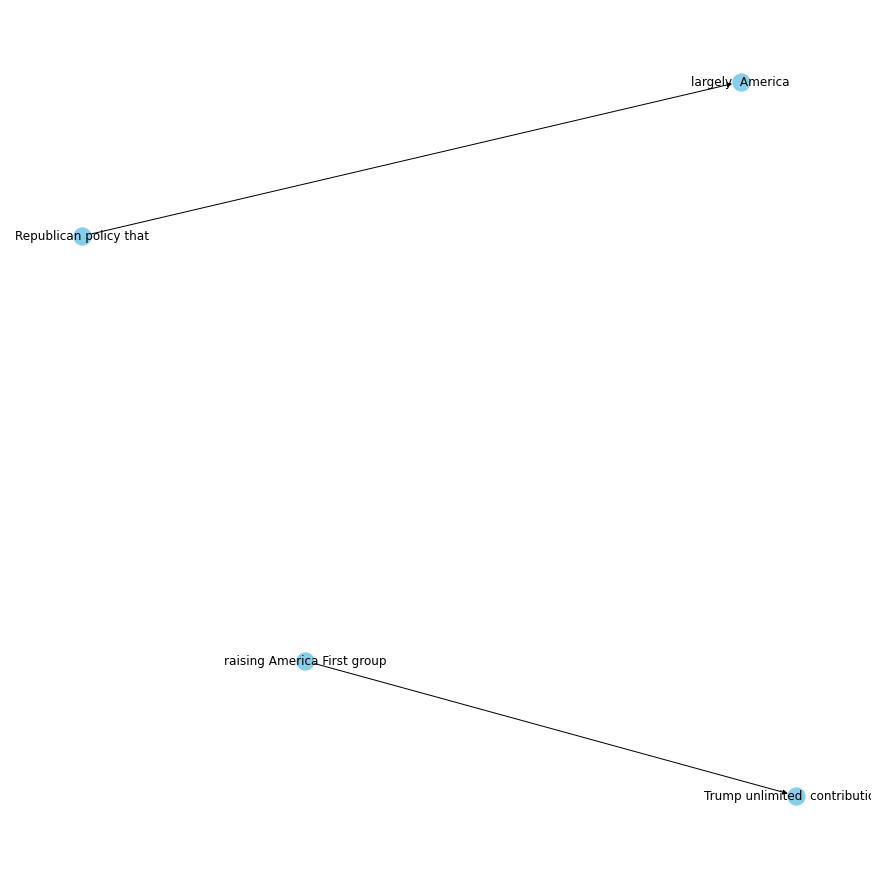

In [26]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [39]:
kg_df['edge'].unique()

array(['gave', 'illustrates'], dtype=object)

### To CSV

In [42]:
#file_path = '/content/drive/Shared drives/1DeepContextGraph/1DeepContextGraph/code/data/'

In [40]:
kg_df.head()
#kg_df.to_csv(file_path+"kg_path.csv")

,source,target,edge
0,raising America First group,Trump unlimited contributions,gave
1,Republican policy that,largely America,illustrates


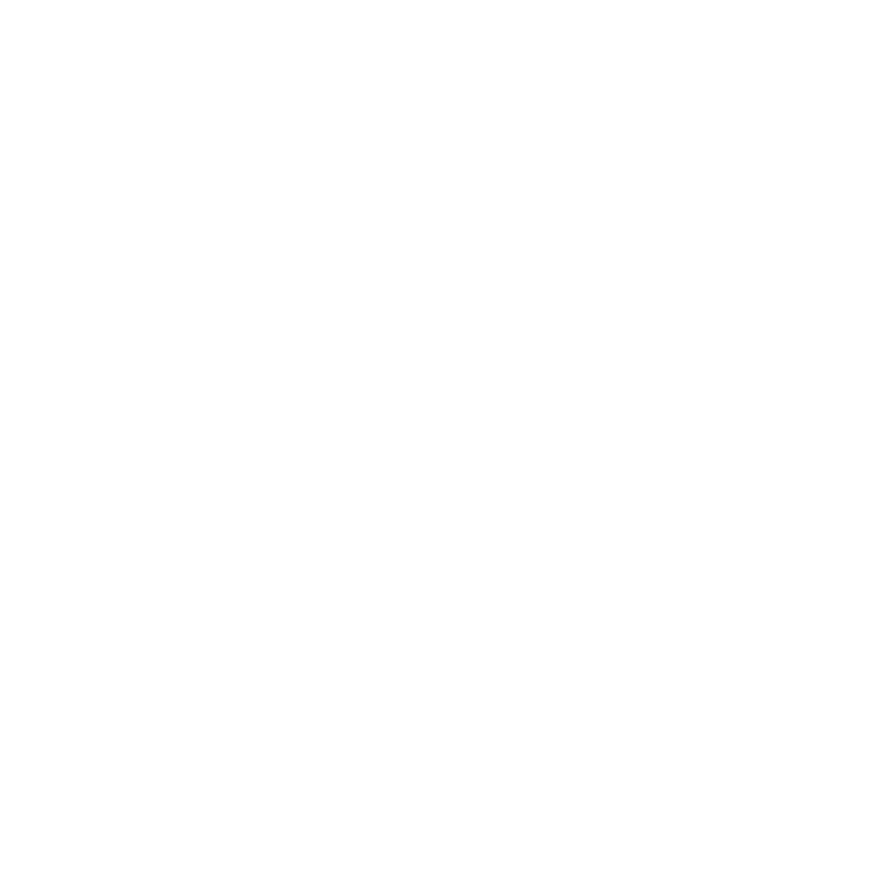

In [42]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="donated"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [43]:
kg_df[kg_df['source']=="Mellon"]

,source,target,edge


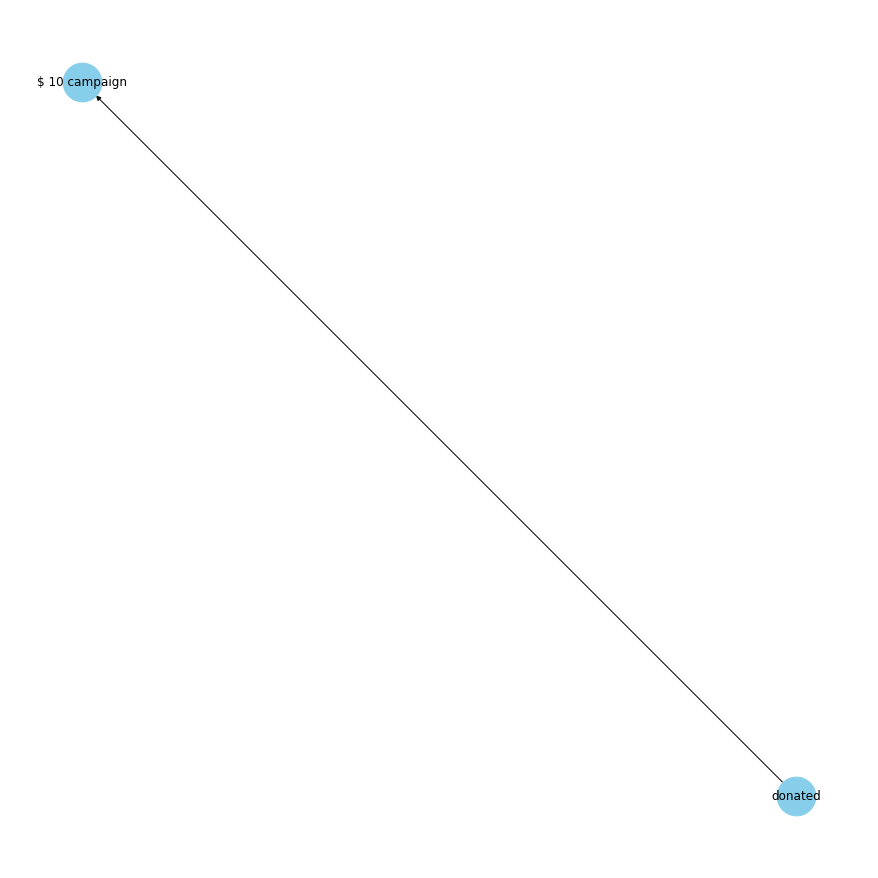

In [46]:

G=nx.from_pandas_edgelist(kg_df[kg_df['source']=="Mellon"], "edge", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

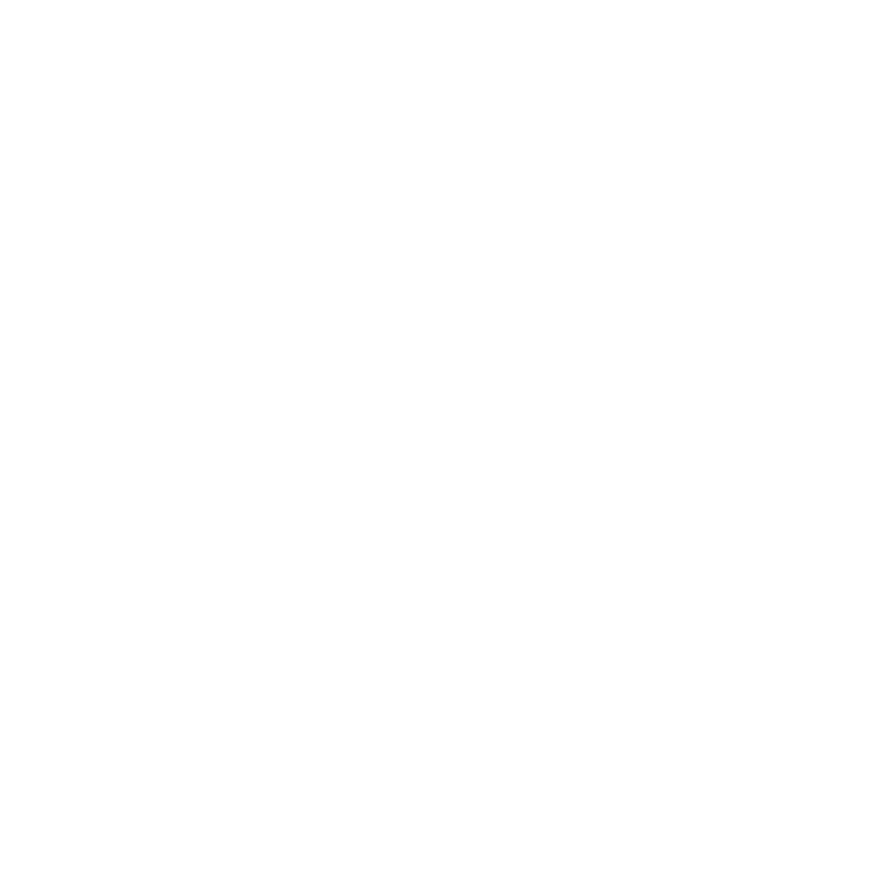

In [47]:

G=nx.from_pandas_edgelist(kg_df[kg_df['target']=="advertisement"], "edge", "source", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## Building Knowledge Graph: Method 2

https://programmerbackpack.com/python-nlp-tutorial-information-extraction-and-knowledge-graphs/

In [124]:
text = '''In a self-published 2015 autobiography, Mellon called social safety net 
programs “Slavery Redux,” adding: “For delivering their votes in the Federal Elections, 
they are awarded with yet more and more freebies: food stamps, cell phones, WIC payments, 
Obamacare, and on, and on, and on. The largess is funded by the hardworking folks, fewer and fewer in number,
 who are too honest or too proud to allow themselves to sink into this morass.
'''

In [27]:
text = article

In [28]:
body = text #summary
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))


This -> det
April -> npadvmod
, -> punct
Mr. -> compound
Mellon -> nsubj
gave -> ROOT
another -> det
$ -> quantmod
10 -> compound
million -> dobj
, -> punct
this -> det
time -> npadvmod
to -> prep
President -> compound
Trump -> nmod
’s -> punct
super -> amod
PAC -> pobj
, -> punct

  -> 
America -> compound
First -> compound
Action -> appos
, -> punct
the -> det
only -> amod
Trump -> npadvmod
- -> punct
endorsed -> amod
fund -> npadvmod
- -> punct
raising -> amod
group -> nsubj
permitted -> acl
to -> aux
collect -> xcomp
unlimited -> amod

  -> 
contributions -> dobj
. -> punct
Mellon group , give super only endorse raise unlimited , million PAC contributions
The -> det
fact -> nsubj
that -> mark
an -> det
outsider -> nsubj
like -> prep
Mr. -> compound
Mellon -> pobj
has -> aux
emerged -> acl
as -> prep
one -> pobj
of -> prep
the -> det
few -> amod

  -> 
supporters -> pobj
willing -> amod
to -> aux
be -> xcomp
so -> advmod
generous -> acomp
illustrates -> ROOT
a -> det
surprising -> a

In [29]:
triples

[('Mellon group',
  'give super only endorse raise unlimited',
  'million PAC contributions'),
 ('fact outsider that',
  'few willing illustrate surprising reliable',
  'Mellon one supporters problem president struggle stable millionaires willing checks takeover Party interests America')]

In [101]:
triples.append(('Mellon',
  'gave',
  'Trump super PAC'))

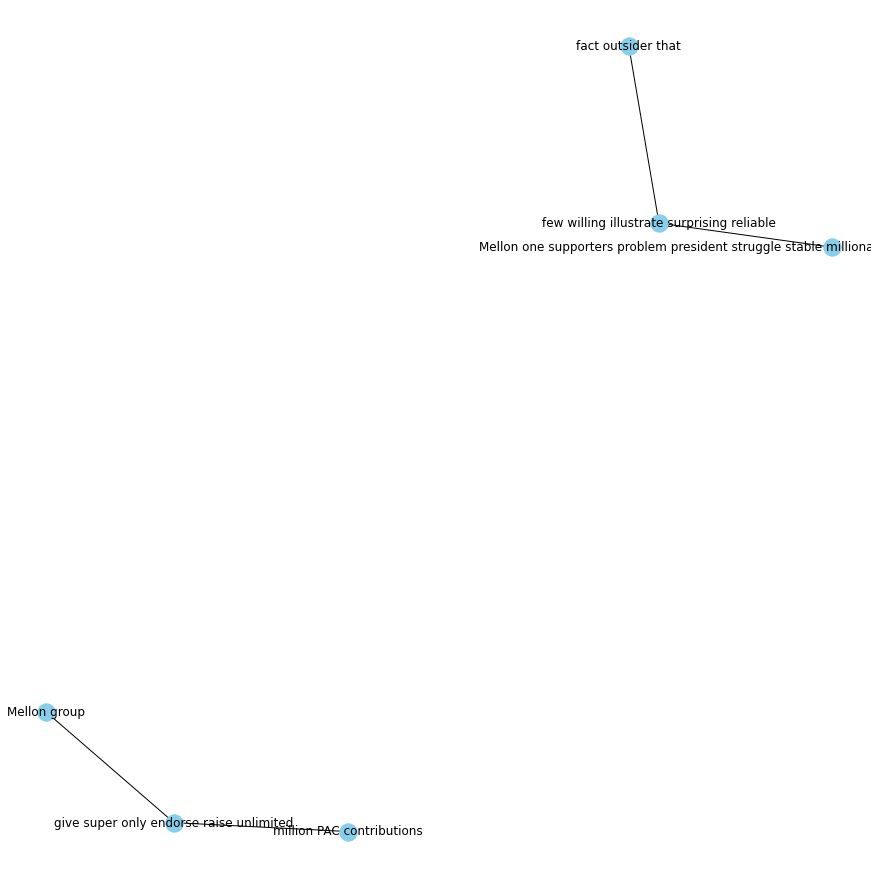

In [50]:
#deps = ["compound", "prep", "conj", "mod"]
printGraph(triples) 

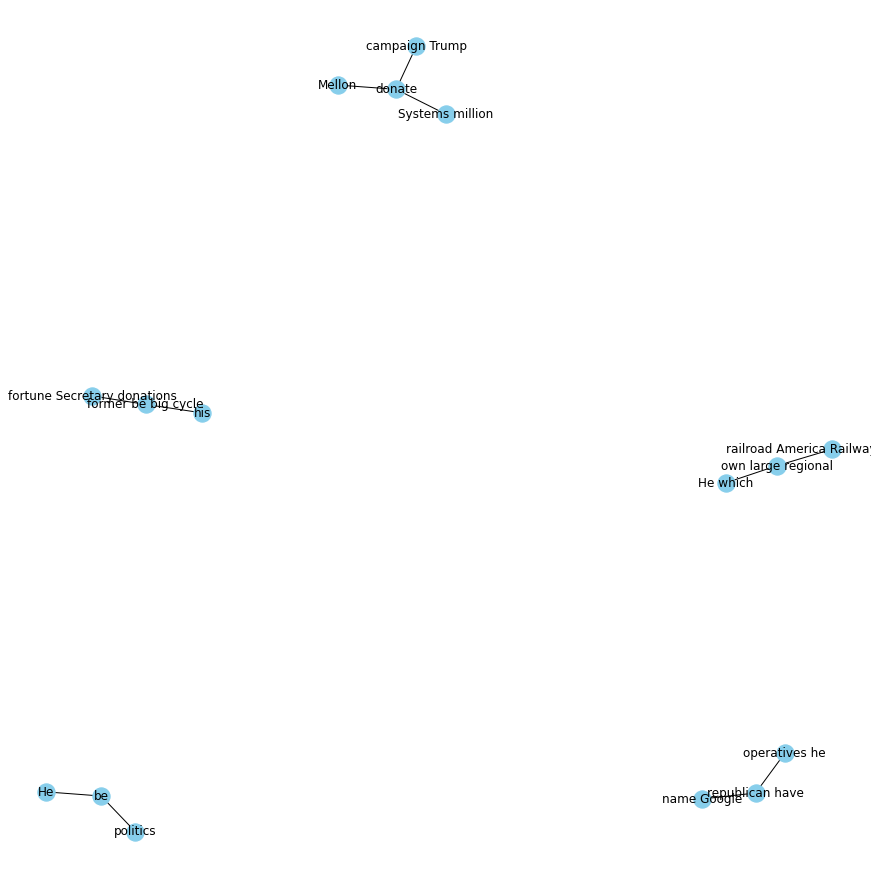

In [85]:
#deps = ["compound", "prep", "conj", "mod", "quantmod", "dobj"]
printGraph(triples) 

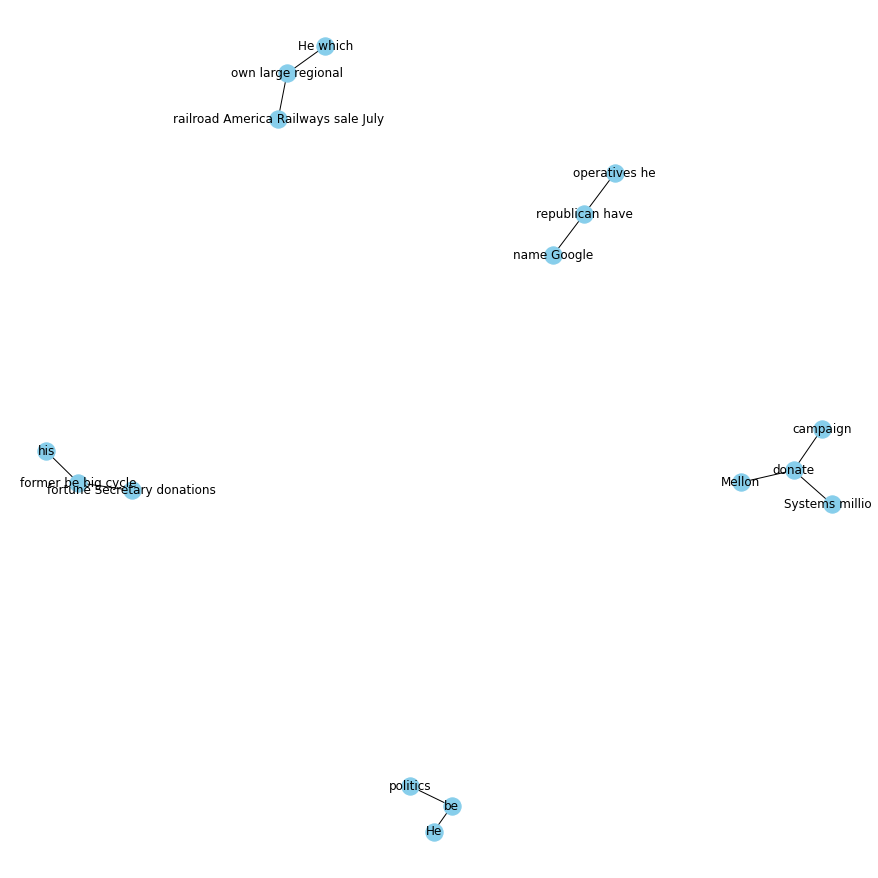

In [80]:
 #deps = ["compound", "prep", "conj", "mod"]
 printGraph(triples) 

order 2-4

1. given url -> provide a df containing all the binary relationship
2. Add "mapping data structure" to the df
3. Visualize: Netwroks
4. Visualize NER; POS; Relationships; => binary graph
5. Transitive micro graph
6. ** Disambiguation

2,4,5

# Identify: Direct Semantic Pattern

## Top Donor List:
 https://www.investopedia.com/articles/investing/033116/top-10-corporate-contributors-trump-campaign.asp

## Direct Pattern_1: X -> VERB -> Y

* VERB(Give/donate/fund/contribute/poured/grants)

In [160]:
triples_save = []

### Donor_1: Timothy Mellon, Pan Am Systems - $10 million

https://www.nytimes.com/2020/08/16/us/politics/trumps-campaign-big-donors.html

#### Methods

In [199]:
def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    #deps = ["compound", "prep", "conj", "mod","nsubj","quantmod","dobj","poss","pobj"] #
    #deps = ["compound", "prep", "conj", "mod", "quantmod", "dobj"] #,"poss"
    # print("##############################")
    # print("isConstructionCandidate token=", token)
    # print("##############################")
    deps = ["compound", "prep", "conj", "mod","nsubj","quantmod","dobj"]
    # print("##############################")
    # print("isConstructionCandidate token=", token)
    # print("isConstructionCandidate token=", any(subs in token.dep_ for subs in deps))
    # print("##############################")
    return any(subs in token.dep_ for subs in deps)
'''
$ -> quantmod
10 -> compound
million -> dobj

Mellon ... nsubj .... ORG
from ... prep .... 
Pan ... compound .... ORG
Am ... compound .... ORG
Systems ... pobj .... ORG
donated ... ROOT .... 
$ ... quantmod .... MONEY
10 ... compound .... MONEY
million ... dobj .... MONEY
to ... prep .... 
Trump ... poss .... PERSON
's ... case .... 
campaign ... pobj .... 
. ... punct .... 
'''
def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
                print("##############################")
                print("subjectConstruction=", subjectConstruction)
                print("##############################")
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
                print("##############################")
                print("objectConstruction=", objectConstruction)
                print("##############################")
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            # print("##############################")
            # print("subject=", subject)
            # print("##############################")
            subjectConstruction = ''
        #special for Amount
        if "MONEY" in token.ent_type_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            print("##############################")
            print("object=", object)
            print("##############################")
            objectConstruction = ''
        # #special case: for Trump (PRODUCT)
        # if "PRODUCT" in token.ent_type_:
        #     object = appendChunk(object, token.text)
        #     object = appendChunk(objectConstruction, object)
        #     print("##############################")
        #     print("object=", object)
        #     print("##############################")
        #     objectConstruction = ''

        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            print("##############################")
            print("object=", object)
            print("##############################")
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)


    plt.show()

#### Input

In [200]:
summary = '''This April, Mr. Mellon gave another $10 million, this time to President Trump’s super PAC,
 America First Action, the only Trump-endorsed fund-raising group permitted to collect unlimited 
 contributions. The fact that an outsider like Mr. Mellon has emerged as one of the few 
 supporters willing to be so generous illustrates a surprising problem for the president: 
 his struggle to attract and retain a reliable stable of millionaires and billionaires willing 
 to write seven-figure checks, despite his takeover of the Republican 
Party and a policy agenda that largely serves the interests of America’s ultrawealthy. '''

#### Building Knowledge Graph: Method 2

https://programmerbackpack.com/python-nlp-tutorial-information-extraction-and-knowledge-graphs/

In [201]:
text = summary

In [202]:
doc = nlp(text)

for tok in doc:
  print(tok.text, "...", tok.dep_, "....", tok.ent_type_)

This ... det .... DATE
April ... npadvmod .... DATE
, ... punct .... 
Mr. ... compound .... 
Mellon ... nsubj .... PERSON
gave ... ROOT .... 
another ... det .... 
$ ... quantmod .... MONEY
10 ... compound .... MONEY
million ... dobj .... MONEY
, ... punct .... 
this ... det .... 
time ... npadvmod .... 
to ... prep .... 
President ... compound .... 
Trump ... nmod .... PERSON
’s ... punct .... 
super ... amod .... 
PAC ... pobj .... ORG
, ... punct .... 

  ...  .... 
America ... compound .... ORG
First ... compound .... ORG
Action ... appos .... ORG
, ... punct .... 
the ... det .... 
only ... amod .... 
Trump ... npadvmod .... PRODUCT
- ... punct .... 
endorsed ... amod .... 
fund ... npadvmod .... 
- ... punct .... 
raising ... amod .... 
group ... nsubj .... 
permitted ... acl .... 
to ... aux .... 
collect ... xcomp .... 
unlimited ... amod .... 

  ...  .... 
contributions ... dobj .... 
. ... punct .... 
The ... det .... 
fact ... nsubj .... 
that ... mark .... 
an ... det ....

In [203]:
body = text #summary
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))


This -> det
April -> npadvmod
, -> punct
Mr. -> compound
Mellon -> nsubj
gave -> ROOT
another -> det
$ -> quantmod
##############################
object=   $
##############################
10 -> compound
##############################
object=    $ 10
##############################
million -> dobj
##############################
object=     $ 10 million
##############################
##############################
object=      $ 10 million million
##############################
, -> punct
this -> det
time -> npadvmod
to -> prep
President -> compound
Trump -> nmod
’s -> punct
super -> amod
PAC -> pobj
##############################
object=       $ 10 million million PAC
##############################
, -> punct

  -> 
America -> compound
First -> compound
Action -> appos
, -> punct
the -> det
only -> amod
Trump -> npadvmod
- -> punct
endorsed -> amod
fund -> npadvmod
- -> punct
raising -> amod
group -> nsubj
permitted -> acl
to -> aux
collect -> xcomp
unlimited -> amod

  -> 
contribution

In [204]:
triples

[('Mellon group',
  'give super only endorse raise unlimited',
  '$ 10 million million PAC contributions'),
 ('fact outsider that',
  'few willing illustrate surprising reliable',
  'Mellon one supporters problem president struggle stable millionaires willing checks takeover Party interests America')]

In [205]:
#connector node (donor -> Trump->type)
triples.append(('Mellon group',
  'super PAC',
  'Trump'))

In [206]:
for triple in triples:
  if triple[0] == 'Mellon group':
    #print(triple)
    triples_save.append(triple)

In [207]:
triples_save

[('Mellon group',
  'give super only endorse raise unlimited',
  '$ 10 million million PAC contributions'),
 ('Mellon group', 'Trump', 'super PAC'),
 ('Warren',
  'LP Sprecher Bloomberg give trump last',
  '$ 10 million million PAC records'),
 ('Warren',
  'give other',
  'about $ 1.7 million million committees Trump $ 1.6 million causes'),
 ('Warren', 'Trump', 'super PAC'),
 ('Palmer who',
  'be long Trump republican',
  'total 7,005,400 7,005,400 campaign cycle'),
 ('Palmer who', 'Trump', 'campaign'),
 ('Mellon group',
  'give super only endorse raise unlimited',
  '$ 10 million million PAC contributions'),
 ('Mellon group', 'super PAC', 'Trump')]

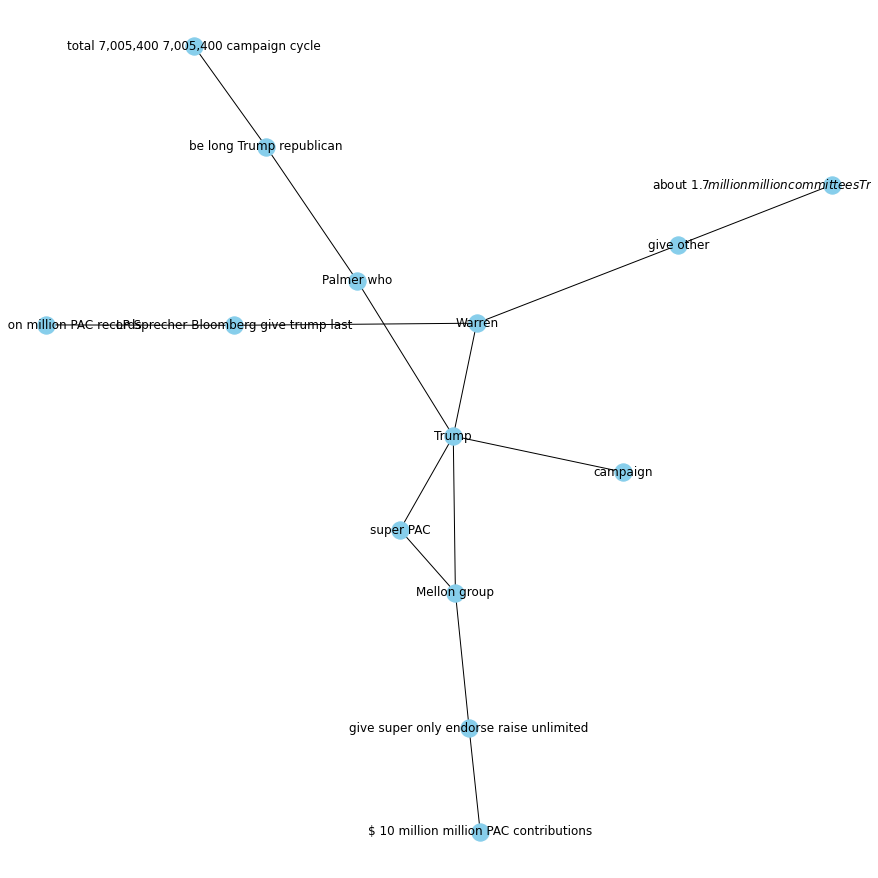

In [208]:
#deps = ["compound", "prep", "conj", "mod"]
printGraph(triples_save) 

### Donor_2: Kelcy Warren, Energy Transfers - $10 million

https://www.forbes.com/sites/michelatindera/2020/09/21/oil-billionaire-gives-10-million-to-pro-trump-super-pac/?sh=5db53c6e4f5d

#### Methods

In [209]:
def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    #deps = ["compound", "prep", "conj", "mod","nsubj","quantmod","dobj","poss","pobj"] #
    #deps = ["compound", "prep", "conj", "mod", "quantmod", "dobj"] #,"poss"
    # print("##############################")
    # print("isConstructionCandidate token=", token)
    # print("##############################")
    deps = ["compound", "prep", "conj", "mod","nsubj","quantmod","dobj"]
    # print("##############################")
    # print("isConstructionCandidate token=", token)
    # print("isConstructionCandidate token=", any(subs in token.dep_ for subs in deps))
    # print("##############################")
    return any(subs in token.dep_ for subs in deps)
'''
$ -> quantmod
10 -> compound
million -> dobj

Mellon ... nsubj .... ORG
from ... prep .... 
Pan ... compound .... ORG
Am ... compound .... ORG
Systems ... pobj .... ORG
donated ... ROOT .... 
$ ... quantmod .... MONEY
10 ... compound .... MONEY
million ... dobj .... MONEY
to ... prep .... 
Trump ... poss .... PERSON
's ... case .... 
campaign ... pobj .... 
. ... punct .... 
'''
def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
                print("##############################")
                print("subjectConstruction=", subjectConstruction)
                print("##############################")
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
                print("##############################")
                print("objectConstruction=", objectConstruction)
                print("##############################")
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            # print("##############################")
            # print("subject=", subject)
            # print("##############################")
            subjectConstruction = ''
        #special for Amount
        if "MONEY" in token.ent_type_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            print("##############################")
            print("object=", object)
            print("##############################")
            objectConstruction = ''
        # #special case: for Trump (PRODUCT)
        # if "PRODUCT" in token.ent_type_:
        #     object = appendChunk(object, token.text)
        #     object = appendChunk(objectConstruction, object)
        #     print("##############################")
        #     print("object=", object)
        #     print("##############################")
        #     objectConstruction = ''

        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            print("##############################")
            print("object=", object)
            print("##############################")
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)


    plt.show()

#### Input

In [210]:
summary = '''Kelcy Warren, chairman and chief executive officer of Energy Transfer Partners LP, during the 2018 CERAWeek by IHS Markit conference in Houston, Texas, on March 7, 2018. © 2018 Bloomberg Finance LP, Photographer: Aaron M. Sprecher/Bloomberg

Oil pipeline billionaire Kelcy Warren gave $10 million to a pro-Trump super-PAC last month, according to Federal Election Commission records released Sunday.

The contribution positions the Dallas tycoon as one of Trump’s top financial supporters in his bid for reelection. Warren and his wife Amy had previously given about $1.7 million to committees directly supporting Trump, and another $1.6 million to other causes this election cycle. In June, they hosted the first in-person fundraiser for Trump after COVID-19 halted in-person events in March.

When Trump took office in 2017, Warren, as head of pipeline manufacturer Energy Transfer Partners, faced protests over construction of the Dakota Access Pipeline. After an executive order from Trump, ETP finished building the pipeline later that year. “I believe that the upcoming election is the most important in a generation,” Warren said in an email to Forbes earlier this year.

The super-PAC, America First Action, reported raising $21.9 million in August. Billionaires, including Warren, contributed some 60% of that. Wisconsin roofing magnate Diane Hendricks poured in $2 million, and Texas banker Andy Beal gave $1 million. Former WWE executive Linda McMahon, who chairs America First, chipped in $500,000.

Other billionaires who have donated to the group include private equity titan Stephen Schwarzman, Arkansas investment banker Warren Stephens, Marlene Ricketts, who is married to TD Ameritrade founder J. Joe Ricketts, and Sequoia Capital managing partner Douglas Leone.

Because America First is a super-PAC, there are no limits on the amount of money its donors can give. The group has spent over $25 million on efforts to support Donald Trump and oppose Joe Biden since last year, according to FEC data. '''

#### Building Knowledge Graph: Method 2

https://programmerbackpack.com/python-nlp-tutorial-information-extraction-and-knowledge-graphs/

In [211]:
text = summary

In [212]:
doc = nlp(text)

for tok in doc:
  print(tok.text, "...", tok.dep_, "....", tok.ent_type_)

Kelcy ... compound .... PERSON
Warren ... ROOT .... PERSON
, ... punct .... 
chairman ... appos .... 
and ... cc .... 
chief ... amod .... 
executive ... amod .... 
officer ... conj .... 
of ... prep .... 
Energy ... compound .... ORG
Transfer ... compound .... ORG
Partners ... compound .... ORG
LP ... pobj .... ORG
, ... punct .... 
during ... prep .... 
the ... det .... EVENT
2018 ... pobj .... EVENT
CERAWeek ... acl .... EVENT
by ... agent .... EVENT
IHS ... compound .... EVENT
Markit ... compound .... EVENT
conference ... pobj .... EVENT
in ... prep .... 
Houston ... pobj .... GPE
, ... punct .... 
Texas ... appos .... GPE
, ... punct .... 
on ... prep .... 
March ... pobj .... DATE
7 ... nummod .... DATE
, ... punct .... DATE
2018 ... appos .... DATE
. ... punct .... 
© ... ROOT .... 
2018 ... nummod .... DATE
Bloomberg ... compound .... ORG
Finance ... compound .... ORG
LP ... ROOT .... ORG
, ... punct .... 
Photographer ... npadvmod .... 
: ... punct .... 
Aaron ... compound ...

In [213]:
body = text #summary
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))


Kelcy -> compound
Warren -> ROOT
, -> punct
chairman -> appos
and -> cc
chief -> amod
executive -> amod
officer -> conj
of -> prep
Energy -> compound
Transfer -> compound
Partners -> compound
LP -> pobj
##############################
object=   LP
##############################
, -> punct
during -> prep
the -> det
2018 -> pobj
##############################
object=    LP 2018
##############################
CERAWeek -> acl
by -> agent
IHS -> compound
Markit -> compound
conference -> pobj
##############################
object=     LP 2018 conference
##############################
in -> prep
Houston -> pobj
##############################
object=      LP 2018 conference Houston
##############################
, -> punct
Texas -> appos
, -> punct
on -> prep
March -> pobj
##############################
object=       LP 2018 conference Houston March
##############################
7 -> nummod
, -> punct
2018 -> nummod
. -> punct
 , Warren chief executive by , LP 2018 conference Houston March
© -

In [214]:
triples

[('', 'Warren chief executive by', 'LP 2018 conference Houston March'),
 ('Warren',
  'LP Sprecher Bloomberg give trump last',
  '$ 10 million million PAC records'),
 ('contribution',
  'position top financial',
  'tycoon one supporters bid reelection'),
 ('Warren',
  'give other',
  'about $ 1.7 million million committees Trump $ 1.6 million causes'),
 ('they COVID-19',
  'host first',
  'June person fundraiser Trump person events March'),
 ('Trump Warren',
  'face',
  'office 2017 head Partners protests construction Pipeline'),
 ('ETP', 'executive finish', 'order Trump pipeline'),
 ('I election Warren', 'upcoming important say', 'generation email Forbes'),
 ('PAC', 'report', '$ 21.9 million million August'),
 ('Billionaires', 'contribute', 'Warren % that'),
 ('Wisconsin Beal',
  'pour',
  'Hendricks $ 2 million million $ 1 million million'),
 ('McMahon who', 'former chip', '500,000 500,000'),
 ('billionaires who who',
  'other include private managing',
  'group Schwarzman Ricketts p

In [215]:
#connector node (donor -> Trump->type)
triples.append(('Warren',
  'super PAC',
  'Trump'))

In [216]:
for triple in triples:
  if triple[0] == 'Warren':
    #print(triple)
    triples_save.append(triple)

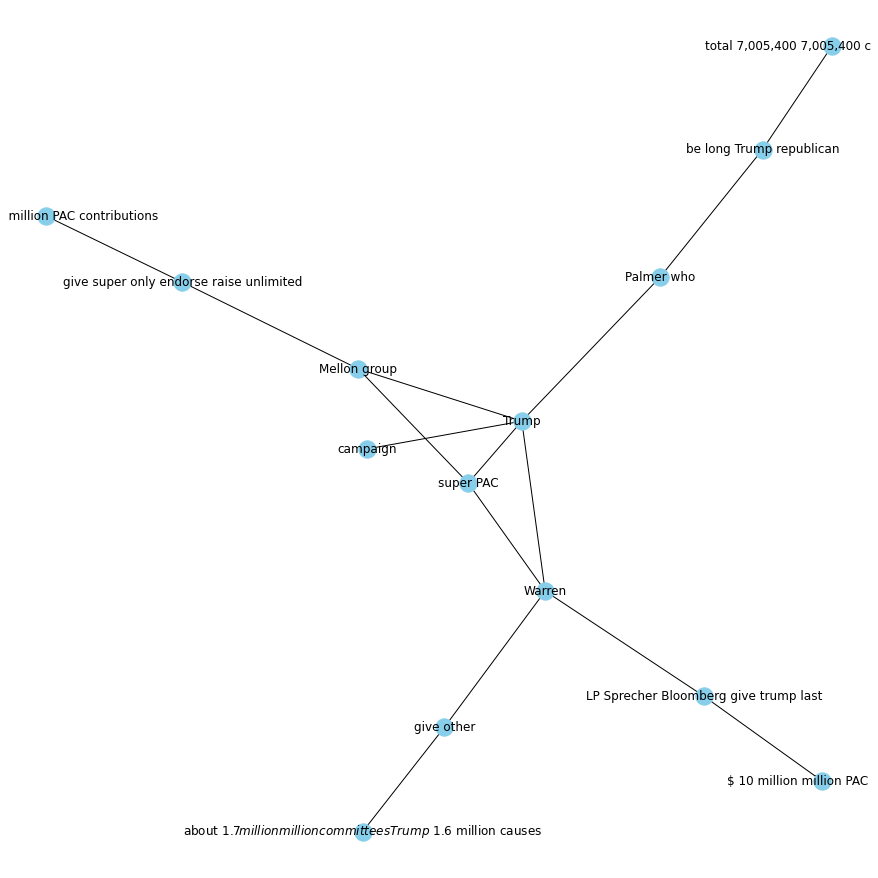

In [217]:
#deps = ["compound", "prep", "conj", "mod"]
printGraph(triples_save) 

### Donor_3: Geoffrey Palmer, G.H. Palmer Associates - $6 million

https://www.forbes.com/sites/michelatindera/2020/09/21/oil-billionaire-gives-10-million-to-pro-trump-super-pac/?sh=5db53c6e4f5d

#### Methods

In [218]:
def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    #deps = ["compound", "prep", "conj", "mod","nsubj","quantmod","dobj","poss","pobj"] #
    #deps = ["compound", "prep", "conj", "mod", "quantmod", "dobj"] #,"poss"
    # print("##############################")
    # print("isConstructionCandidate token=", token)
    # print("##############################")
    deps = ["compound", "prep", "conj", "mod","nsubj","quantmod","dobj"]
    # print("##############################")
    # print("isConstructionCandidate token=", token)
    # print("isConstructionCandidate token=", any(subs in token.dep_ for subs in deps))
    # print("##############################")
    return any(subs in token.dep_ for subs in deps)
'''
$ -> quantmod
10 -> compound
million -> dobj

Mellon ... nsubj .... ORG
from ... prep .... 
Pan ... compound .... ORG
Am ... compound .... ORG
Systems ... pobj .... ORG
donated ... ROOT .... 
$ ... quantmod .... MONEY
10 ... compound .... MONEY
million ... dobj .... MONEY
to ... prep .... 
Trump ... poss .... PERSON
's ... case .... 
campaign ... pobj .... 
. ... punct .... 
'''
def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
                print("##############################")
                print("subjectConstruction=", subjectConstruction)
                print("##############################")
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
                print("##############################")
                print("objectConstruction=", objectConstruction)
                print("##############################")
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            # print("##############################")
            # print("subject=", subject)
            # print("##############################")
            subjectConstruction = ''
        #special for Amount
        if "MONEY" in token.ent_type_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            print("##############################")
            print("object=", object)
            print("##############################")
            objectConstruction = ''
        # #special case: for Trump (PRODUCT)
        # if "PRODUCT" in token.ent_type_:
        #     object = appendChunk(object, token.text)
        #     object = appendChunk(objectConstruction, object)
        #     print("##############################")
        #     print("object=", object)
        #     print("##############################")
        #     objectConstruction = ''

        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            print("##############################")
            print("object=", object)
            print("##############################")
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)


    plt.show()

#### Input

In [219]:
summary = '''According to a Los Angeles Times report tracking total donations town by town,
 Beverly Hills donated a total of $9,337,672 to the president's re-election campaign, and
  was one of the few communities on the Westside where he outraised Joe Biden.

Much of that total came from real estate developer Geoffrey Palmer, whose $6,405,200 was 
the largest individual donation in California. Palmer is a long-time Trump and 
Republican donor who donated a total of $7,005,400 to the Trump campaign during the 2016 cycle.
 In September 2019 Trump visited Palmer's Beverly Hills home — which was once home
  to Burton E. Green, the oilman and real estate developer who helped found 
and name Beverly Hills in the early 20th century — for a fundraiser. '''

#### Building Knowledge Graph: Method 2

https://programmerbackpack.com/python-nlp-tutorial-information-extraction-and-knowledge-graphs/

In [220]:
text = summary

In [221]:
doc = nlp(text)

for tok in doc:
  print(tok.text, "...", tok.dep_, "....", tok.ent_type_)

According ... prep .... 
to ... prep .... 
a ... det .... 
Los ... compound .... ORG
Angeles ... compound .... ORG
Times ... compound .... ORG
report ... pobj .... 
tracking ... acl .... 
total ... amod .... 
donations ... dobj .... 
town ... dobj .... 
by ... prep .... 
town ... pobj .... 
, ... punct .... 

  ...  .... 
Beverly ... compound .... GPE
Hills ... nsubj .... GPE
donated ... ROOT .... 
a ... det .... 
total ... dobj .... 
of ... prep .... 
$ ... nmod .... 
9,337,672 ... pobj .... MONEY
to ... prep .... 
the ... det .... 
president ... poss .... 
's ... case .... 
re ... dep .... 
- ... dep .... 
election ... amod .... 
campaign ... pobj .... 
, ... punct .... 
and ... cc .... 

   ...  .... 
was ... conj .... 
one ... attr .... CARDINAL
of ... prep .... 
the ... det .... 
few ... amod .... 
communities ... pobj .... 
on ... prep .... 
the ... det .... 
Westside ... pobj .... 
where ... advmod .... 
he ... nsubj .... 
outraised ... relcl .... 
Joe ... compound .... PERSON
B

In [222]:
body = text #summary
sentences = getSentences(body)
nlp_model = spacy.load('en_core_web_sm')

triples = []
#print (body)
for sentence in sentences:
  triples.append(processSentence(sentence))


According -> prep
to -> prep
a -> det
Los -> compound
Angeles -> compound
Times -> compound
report -> pobj
##############################
object=   report
##############################
tracking -> acl
total -> amod
donations -> dobj
##############################
object=    report donations
##############################
town -> dobj
##############################
object=     report donations town
##############################
by -> prep
town -> pobj
##############################
object=      report donations town town
##############################
, -> punct

  -> 
Beverly -> compound
Hills -> nsubj
donated -> ROOT
a -> det
total -> dobj
##############################
object=       report donations town town total
##############################
of -> prep
$ -> nmod
9,337,672 -> pobj
##############################
object=        report donations town town total 9,337,672
##############################
##############################
object=         report donations town town total 9

In [223]:
triples

[('Hills he',
  'total donate election one few',
  'report donations town town total 9,337,672 9,337,672 campaign communities Westside Biden'),
 ('Much 6,405,200',
  'come real large individual donation',
  'total Palmer 6,405,200 California'),
 ('Palmer who',
  'be long Trump republican',
  'total 7,005,400 7,005,400 campaign cycle'),
 ('Trump which who',
  'visit real early 20th',
  'September home Green Hills century fundraiser')]

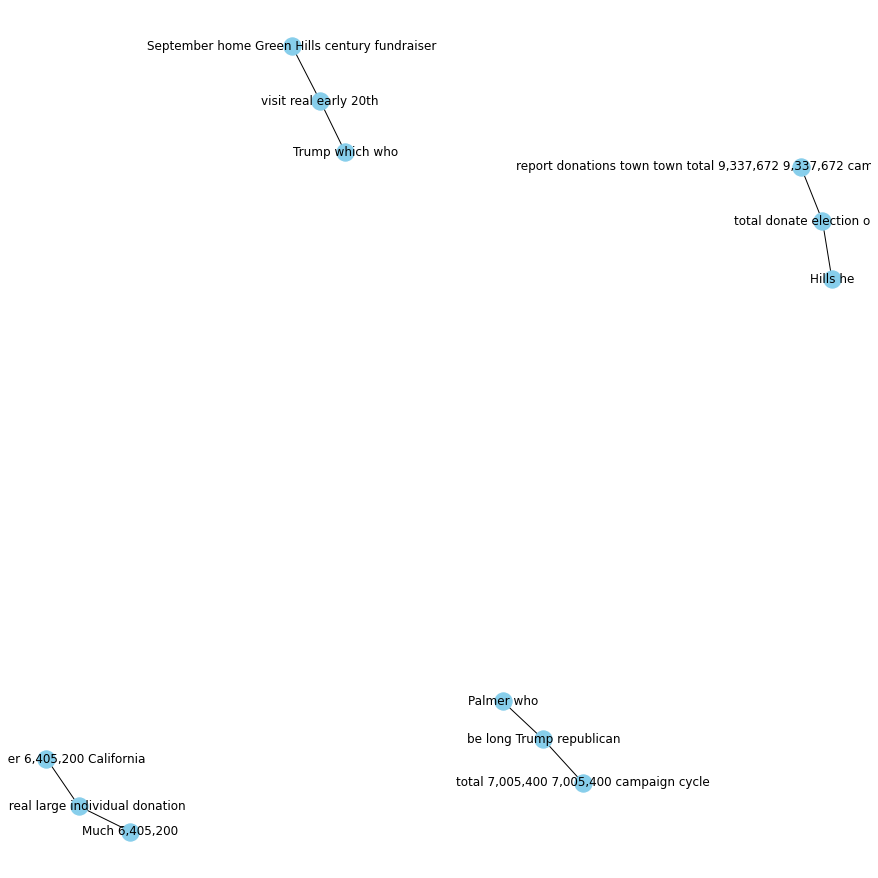

In [224]:
#deps = ["compound", "prep", "conj", "mod"]
printGraph(triples)

In [225]:
#connector node (donor -> Trump->type)
triples.append(('Palmer who',
  'campaign',
  'Trump'))

In [226]:
for triple in triples:
  if triple[0] == 'Palmer who':
    #print(triple)
    triples_save.append(triple)

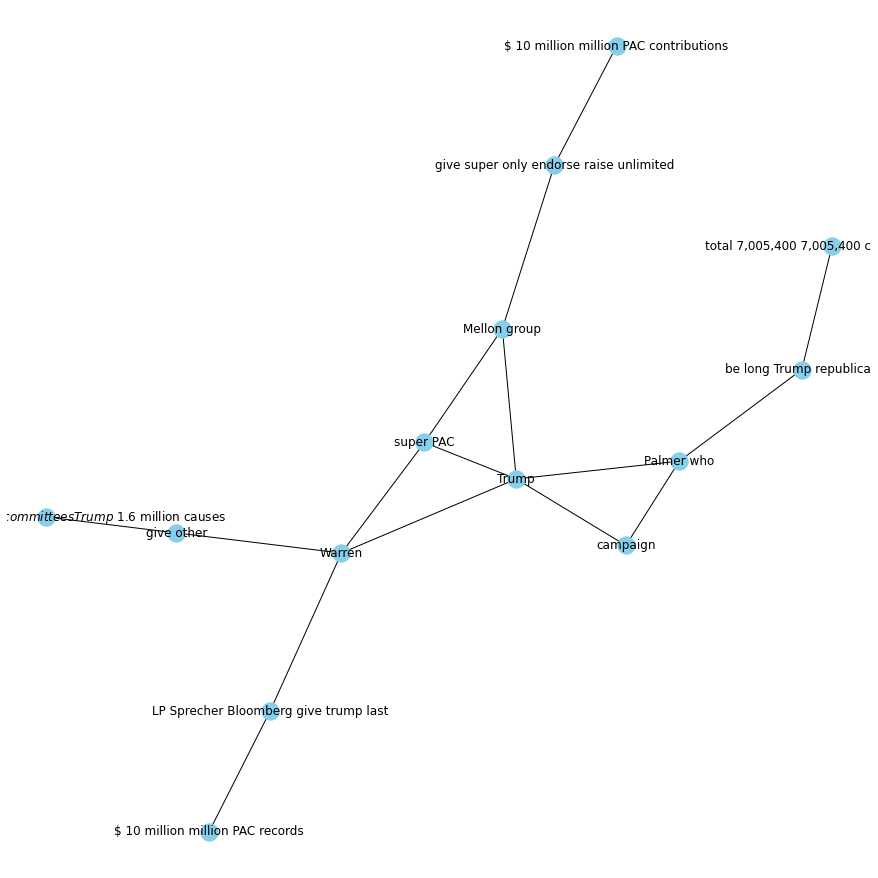

In [227]:
#deps = ["compound", "prep", "conj", "mod"]
printGraph(triples_save) 